You can order print and ebook versions of *Think Bayes 2e* from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

# The Raven Paradox

Suppose you are not sure whether all ravens are black.
If you see a white raven, that would clearly refute the hypothesis.
And if you see a black raven, that would support the hypothesis in the sense that it increases our confidence, maybe slightly.
But what if you see a red apple -- does that make the hypothesis any more or less likely?

This question is the core of the [Raven paradox](https://en.wikipedia.org/wiki/Raven_paradox), a problem in the philosophy of science posed by Carl Gustav Hempel in the 1940s.
It highlights a counterintuitive aspect of how we evaluate evidence and confirm hypotheses.

No resolution of the paradox is universally accepted, but the most widely accepted is what I will call the standard Bayesian response.
In this article, I'll present this response, explain why I think it is incomplete, and propose an extension that might resolve the paradox.

In [1]:
# install empiricaldist if necessary
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils import decorate, set_pyplot_params
from utils import make_joint, make_mesh, normalize, marginal

In [4]:
np.random.seed(0)
np.set_printoptions(legacy='1.25')
set_pyplot_params()

## The Problem

The paradox starts with the hypothesis

A: All ravens are black

And the contrapositive hypothesis

B: All non-black things are non-ravens

Logically, these hypotheses are identical -- if A is true, B must be true, and vice versa.
So if we have a certain level of confidence in A, we should have exactly the same confidence in B.

And if we observe data that is evidence in favor of A, we should also accept it as evidence in favor of B, to the same degree.

Also, if we accept that a black raven is evidence in favor of A, we should also accept that a non-black non-raven is evidence in favor of B.

Finally, if a non-black non-raven is evidence in favor of B, we should also accept that it is evidence in favor of A.

Therefore, a red apple (which is a non-black non-raven) is evidence that all ravens are black.

If you accept this conclusion, it seems like every time you see a red apple (or a blue car, or a green leaf, etc.) you should think, "Now I am slightly more confident that all ravens are black (and all flamingos are pink, etc.)".

But that seems absurd, so we have two options:

1) Discover an error in the argument, or

2) Accept the conclusion.

As you might expect, people have proposed many versions of (1) and (2).
The standard Bayesian response is to accept the conclusion but, [quoth Wikipedia](https://en.wikipedia.org/wiki/Raven_paradox#Standard_Bayesian_solution) "argue that the amount of confirmation provided is very small, due to the large discrepancy between the number of ravens and the number of non-black objects. According to this resolution, the conclusion appears paradoxical because we intuitively estimate the amount of evidence provided by the observation of a green apple to be zero, when it is in fact non-zero but extremely small."

In my opinion, the standard Bayesian response is correct but incomplete.
It is true that when the number of non-ravens is large, the amount of evidence we get from each non-black non-raven is so small it is negligible.
But I don't think that's *why* the conclusion is so acutely counterintuitive.

To clarify my objection, let me present a smaller example I'll call the Roulette paradox.
An American roulette wheel has 36 pockets with the numbers `1` to `36`, and two pockets labeled `0` and `00`.
The non-zero pockets are red or black, and the zero pockets are green.

Suppose we work in quality control at the roulette factory and our job is to check that all zero pockets are green.
If we observe a green zero, that's evidence that all zeros are green.
But what if we observe a red 19?

In this example, the standard Bayesian response fails twice over

* The number of non-zeros is not particularly large, so the weight of the evidence is not negligible, and

* The Bayesian response doesn't address what I think is actually the key: The non-green non-zero **may or may not be evidence**, depending on how it was sampled.

As I will demonstrate, 

1) If we choose a pocket at random and it turns out to be a non-green non-zero, that *is not* evidence that all zeros are green.

2) But if we choose a non-green pocket and it turns out to be non-zero, that *is* evidence that all zeros are green.

In both cases we observe a non-green non-zero, but here's the key: "observe" is ambiguous. Whether the observation is evidence or not **depends on the sampling process** that generated the observation.
And I think confusion between these two scenarios is the foundation of the paradox.

## The Setup

Now let's get to the details.
Switching from roulette back to ravens, we will consider four scenarios:

1. You choose a random thing and it turns out to be a black raven.

2. You choose a random thing and it turns out to be a non-black non-raven (say a red apple).

3. You choose a random raven and it turns out to be black.

4. You choose a random non-black thing and it turns out to be a non-raven.

We'll start with a small world where there are only `N = 9` ravens and `M = 19` non-ravens.
Then we'll see what happens as we vary `N` and `M`.

In [5]:
N = 9
M = 19

I'll use `i` to represent the unknown number of black ravens, which could be any value from `0` to `N`, and `j` to represent the unknown number of black non-ravens, from `0` to `M`.

We'll use a joint distribution to represent beliefs about `i` and `j`; then we'll use Bayes's Theorem to update these beliefs when we see new data.

Let's start with a uniform prior over all possible combinations of `(i, j)`.

In [6]:
from empiricaldist import Pmf

prior_i = Pmf(1, np.arange(N + 1))  # beliefs about i (number of black ravens)
prior_j = Pmf(1, np.arange(M + 1))  # beliefs about j (number of black non-ravens)

prior = make_joint(prior_i, prior_j)
normalize(prior);

If `i = N`, that means all ravens are black, so we can compute the prior probability of `A` like this.

In [7]:
prior_A = prior[N].sum()
prior_A

0.10000000000000002

For this prior, the probability of `A` is 10%.
We'll see later that the prior affects the strength of the evidence we see, but it doesn't affect whether an observation is in favor of `A` or not.

## Scenario 1

Now let's consider the first scenario: we choose a thing at random from the universe of things, and we find that it is a black raven.

The likelihood for this observation is: `i / (N + M)`, because `i` is the number of black ravens and `N + M` is the total number of things.

The following function computes the posterior distribution of `i` and `j` in this scenario.

In [8]:
def update_scenario1(prior, N, M):
    # Create meshgrids for i and j
    I, J = make_mesh(prior)

    # Compute likelihood for Scenario 1
    likelihood = I / (N + M)

    # Perform Bayesian update
    posterior = prior * likelihood
    normalize(posterior)
    
    return posterior

Here's the update.

In [9]:
posterior = update_scenario1(prior, N, M)

And here's the posterior probability of A.

In [10]:
posterior_A = posterior[N].sum()
posterior_A

0.20000000000000004

To quantify the strength of the evidence, we'll compute the ratio of the posterior and prior probabilities.

In [11]:
ratio = posterior_A / prior_A
ratio

2.0

This ratio is greater than `1`, so the black raven is evidence in favor of `A`.

Before we go on, let's also look at the marginal distribution of `i` (number of black ravens) before and after.

In [12]:
marginal_i_prior = marginal(prior, axis=0)
marginal_i_posterior = marginal(posterior, axis=0)

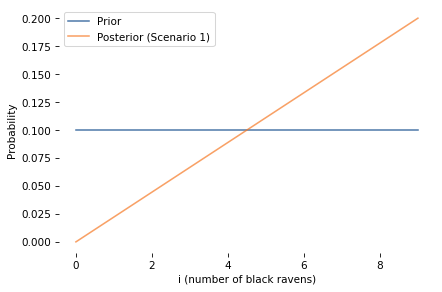

In [13]:
marginal_i_prior.plot(label='Prior', alpha=0.7)
marginal_i_posterior.plot(label='Posterior (Scenario 1)', alpha=0.7)
decorate(xlabel='i (number of black ravens)', 
         ylabel='Probability')
plt.savefig('raven_scenario1_marginal.png', dpi=150)

As expected, observing a black raven increases our confidence that all ravens are black.
The posterior distribution shifts toward higher values of `i`, and the probability that `i = N` increases.

In Scenario 1, the likelihood depends only on `i`, not on `j`, so the update doesn't change our beliefs about `j` (the number of black non-ravens).
We can verify this by comparing the prior and posterior distributions of `j`:

In [14]:
marginal_j_prior = marginal(prior, axis=1)
marginal_j_posterior = marginal(posterior, axis=1)

np.allclose(marginal_j_prior, marginal_j_posterior)

True

Finally, let's visualize posterior joint distribution of `i` and `j`.

In [15]:
def plot_joint(joint):
    # Transpose so i (number of black ravens) is on y-axis
    plt.imshow(joint.T, cmap='Blues')
    plt.gca().invert_yaxis()
    decorate(xlabel='j (number of black non-ravens)', 
             ylabel='i (number of black ravens)')

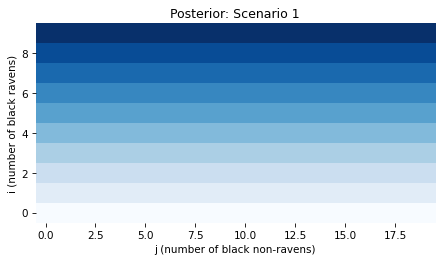

In [16]:
plot_joint(posterior)
plt.title('Posterior: Scenario 1')
plt.savefig('raven_scenario1.png', dpi=150)

Because we started with a uniform distribution and the data has no bearing on `j`, the joint posterior probabilities don't depend on `j`.

In summary, Scenario 1 is consistent with intuition: a black raven is evidence in favor of `A`.

## Scenario 2

In this scenario, we choose a thing at random from the universe of `N + M` things, and it turns out to be a red apple -- which we will treat generally as a non-black non-raven.

The likelihood of this observation is: `(M - j) / (N + M)`, because `M - j` is the number of non-black non-ravens and `N + M` is the total number of things.

The following function computes the posterior distribution of `i` and `j` in this scenario.

In [17]:
def update_scenario2(prior, N, M):
    # Create meshgrids for i and j
    I, J = make_mesh(prior)

    # Compute likelihood for Scenario 2
    likelihood = (M - J) / (N + M)

    # Perform Bayesian update
    posterior = prior * likelihood
    normalize(posterior)
    
    return posterior

Here's the update.

In [18]:
posterior = update_scenario2(prior, N, M)

And here's the posterior probability of A.

In [19]:
posterior_A = posterior[N].sum()
posterior_A

0.1

In this scenario, the posterior probability of `A` is the same as the prior.
In fact, the entire distribution of `i` is unchanged.

In [20]:
marginal_i_prior = marginal(prior, axis=0)
marginal_i_posterior = marginal(posterior, axis=0)

np.allclose(marginal_i_prior, marginal_i_posterior)

True

So the red apple  is not evidence in favor of `A` or against it.
This is consistent with the intuition that the red apple (or any non-black non-raven) is irrelevant.

However, the red apple is evidence about `j`, as we can confirm by comparing the marginal distribution of `j` before and after.

In [21]:
marginal_j_prior = marginal(prior, axis=1)
marginal_j_posterior = marginal(posterior, axis=1)

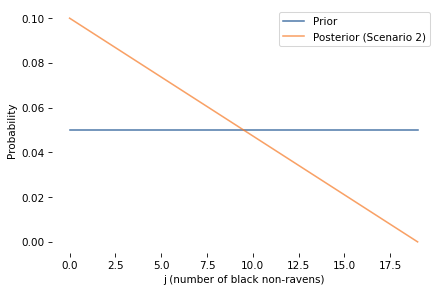

In [22]:
marginal_j_prior.plot(label='Prior', alpha=0.7)
marginal_j_posterior.plot(label='Posterior (Scenario 2)', alpha=0.7)
decorate(xlabel='j (number of black non-ravens)', 
         ylabel='Probability')
plt.savefig('raven_scenario2_marginal.png', dpi=150)

And here's the posterior joint distribution of `i` and `j`.

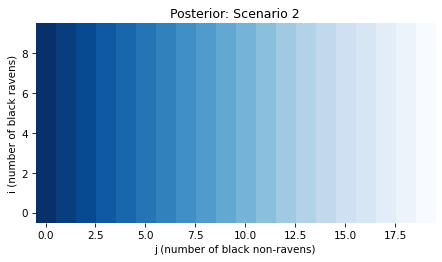

In [23]:
plot_joint(posterior)
plt.title('Posterior: Scenario 2')
plt.savefig('raven_scenario2.png', dpi=150)

Because the red apple has no bearing on `i`, the posterior probabilities in this scenario don't depend on `i`.

In summary, Scenario 2 matches our intuition: a red apple (chosen at random) is *not* evidence about whether all ravens are black.

## Scenario 3

In this scenario, we choose a raven first and then observe that it is black.

The likelihood for this observation is: `i / N`, because `i` is the number of black ravens and `N` is the total number of ravens.

The following function computes the posterior distribution of `i` and `j` in this scenario.

In [24]:
def update_scenario3(prior, N, M):
    # Create meshgrids for i and j
    I, J = make_mesh(prior)

    # Compute likelihood for Scenario 3
    likelihood = I / N

    # Perform Bayesian update
    posterior = prior * likelihood
    normalize(posterior)
    
    return posterior

Here's the update.

In [25]:
posterior = update_scenario3(prior, N, M)

And here's the posterior probability of A.

In [26]:
posterior_A = posterior[N].sum()
posterior_A

0.20000000000000004

This posterior is the same as in Scenario 1, so we conclude that the black raven is evidence in favor of `A`, with the same strength regardless of whether we are in:

* Scenario 1: Select a random thing and it turns out to be a black raven or

* Scenario 3: Select a random raven and it turns out to be black.

In fact, the entire posterior distribution is the same in both scenarios.

In summary, Scenario 3 is consistent with intuition: a black raven (chosen from ravens) is evidence in favor of `A`.

## Scenario 4

In the last scenario, we first choose a non-black thing (from all non-black things in the universe), and then observe that it is a non-raven.

The likelihood of this observation is: `(M - j) / (N - i + M - j)` because `M - j` is the number of non-black non-ravens and `N - i + M - j` is the total number of non-black things.

This likelihood depends on **both** `i` and `j`, unlike Scenario 2.
This is the key difference that makes Scenario 4 informative about whether all ravens are black.

The following function computes the posterior distribution of `i` and `j` in this scenario.

In [27]:
def update_scenario4(prior, N, M):
    # Create meshgrids for i and j
    I, J = make_mesh(prior)

    # Compute likelihood for Scenario 4
    num = M - J
    den = N - I + M - J
    likelihood = np.divide(num, den, where=(den != 0))

    # Perform Bayesian update
    posterior = prior * likelihood
    normalize(posterior)
    
    return posterior

Here's the update.

In [28]:
posterior = update_scenario4(prior, N, M)

And here's the posterior probability of A.

In [29]:
posterior_A = posterior[N].sum()
posterior_A

0.14940297326954258

Again, we can quantify the strength of the evidence by computing the ratio of the posterior and prior probabilities.

In [30]:
ratio = posterior_A / prior_A
ratio

1.4940297326954255

This ratio is greater than `1`, so the non-black non-raven is evidence in favor of `A`.

The ratio is smaller than in Scenario 1 and Scenario 3, because there are more non-ravens than ravens.
As we'll see, this ratio gets smaller as `M` gets bigger.

Here is the marginal distribution of `i` (number of black ravens):

In [31]:
marginal_i_prior = marginal(prior, axis=0)
marginal_i_posterior = marginal(posterior, axis=0)

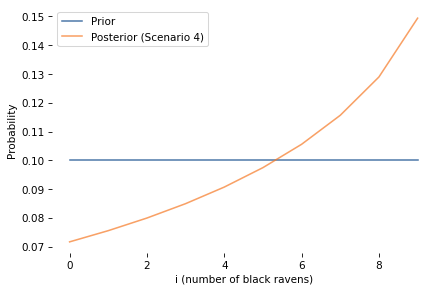

In [32]:
marginal_i_prior.plot(label='Prior', alpha=0.7)
marginal_i_posterior.plot(label='Posterior (Scenario 4)', alpha=0.7)
decorate(xlabel='i (number of black ravens)', 
         ylabel='Probability')
plt.savefig('raven_scenario4_marginal_i.png', dpi=150)

And here's the marginal distribution of `j` before and after.

In [33]:
marginal_j_prior = marginal(prior, axis=1)
marginal_j_posterior = marginal(posterior, axis=1)

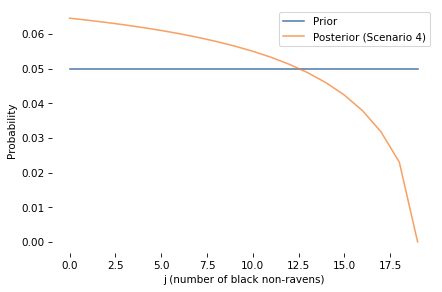

In [34]:
marginal_j_prior.plot(label='Prior', alpha=0.7)
marginal_j_posterior.plot(label='Posterior (Scenario 4)', alpha=0.7)
decorate(xlabel='j (number of black non-ravens)', 
         ylabel='Probability')
plt.savefig('raven_scenario4_marginal_j.png', dpi=150)

Finally, here's the posterior joint distribution of `i` and `j`.

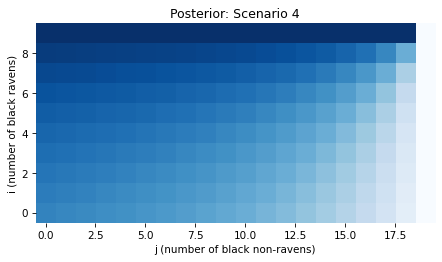

In [35]:
plot_joint(posterior)
plt.title('Posterior: Scenario 4')
plt.savefig('raven_scenario4.png', dpi=150)

In Scenario 4, the likelihood depends on **both** `i` and `j`, so the update changes our beliefs about both parameters.

And in Scenario 4 a non-black non-raven (chosen from non-black things) is evidence in favor of `A`.
This might still be surprising, but let me suggest a way to think about it: in this scenario we are checking non-black things to make sure they are not ravens.
If we find a non-black raven that would contradict `A`.
If we don't, that supports `A`.


In all four scenarios, the results are consistent with intuition.
So as long as you are clear about which scenario you are in, there is no paradox.
The paradox is only confusing if you think you are in Scenario 2 and you imagine the result from Scenario 4.

In the context of the original problem:

1) If you walk out of your house and the first thing you see is a red apple (or a blue car, or a green leaf) that has no bearing on whether raven are black.

2) If you deliberately select a non-black thing and check whether it's a raven, and you find that it is not, that actually is evidence that all ravens are black -- but consistent with the standard Bayesian response, it is so weak it is negligible.

## Successive updates

In these examples, we started with a uniform prior over all combinations of `i` and `j`.
Of course that's not a realistic description of what we believe about the world.
So let's consider the effect of other priors.

In general, different priors lead to different posterior distributions, and in this case they lead to different conclusions about the *strength* of the evidence.
But they lead to the same conclusion about the *direction* of the evidence.

To demonstrate, let's see what happens if we observe a series of black ravens (in Scenario 1 or 3).
For simplicity, we'll assume that we sample with replacement.

The following function computes multiple updates, starting with the uniform prior and then using the posterior from each update as the prior for the next.

In [36]:
from scipy.special import logit

def multiple_updates(prior, update_func, N, M, iters=10):
    joint = prior.copy()
    res = []
    for i in range(iters):
        prior_A = joint[N].sum()
        joint = update_func(joint, N, M)
        posterior_A = joint[N].sum()
        res.append((prior_A, posterior_A))

    return make_table(res)

def make_table(res, columns=None):
    columns = columns if columns is not None else ['Prior', 'Posterior'] 
    res_df = pd.DataFrame(res, columns=columns)
    res_df['Ratio'] = res_df['Posterior'] / res_df['Prior']
    res_df['LOR'] = logit(res_df['Posterior']) - logit(res_df['Prior'])
    res_df.index.name = 'Iteration'
    return res_df

This table shows the results in Scenario 1 (which is the same as in Scenario 3).
For each iteration, the table shows the prior and posterior probability of `A`, the ratio of the probabilities, and the log odds ratio.

In [37]:
multiple_updates(prior, update_scenario1, N, M)

,Prior,Posterior,Ratio,LOR
Iteration,,,,
0,0.100000,0.200000,2.000000,0.810930
1,0.200000,0.284211,1.421053,0.462624
2,0.284211,0.360000,1.266667,0.348307
3,0.360000,0.427901,1.188613,0.284942
4,0.427901,0.488715,1.142123,0.245274
5,0.488715,0.543171,1.111426,0.218261
6,0.543171,0.591920,1.089750,0.198796
7,0.591920,0.635551,1.073710,0.184196
8,0.635551,0.674590,1.061426,0.172914


As we see more ravens, the posterior probability of `A` increases, but the ratio decreases -- which means that each raven provides weaker evidence than the previous one.
However, in the long run the LOR converges to a value greater than 0 (about 0.11), which means that each raven provides at least some additional evidence, even when the prior is far from the uniform distribution we started with.

In the worst case, if the prior probability of `A` is `0` or `1`, nothing we observe can change those beliefs, so nothing is evidence for or against `A`.
But there is no prior where a black raven provides evidence *against* `A`.

The following table shows the results in Scenario 4, where we select a non-black thing and check that it is not a raven.

In [38]:
multiple_updates(prior, update_scenario4, N, M)

,Prior,Posterior,Ratio,LOR
Iteration,,,,
0,0.100000,0.149403,1.494030,0.457933
1,0.149403,0.201006,1.345394,0.359272
2,0.201006,0.253991,1.263601,0.302582
3,0.253991,0.307217,1.209556,0.264273
4,0.307217,0.359496,1.170171,0.235611
5,0.359496,0.409837,1.140031,0.212911
6,0.409837,0.457528,1.116368,0.194344
7,0.457528,0.502141,1.097508,0.178860
8,0.502141,0.543477,1.082320,0.165785


The pattern is similar.
Each non-black thing that turns out not to be a raven is evidence in favor of `A`, and each one is weaker evidence than the previous one.
But it is always in favor of `A` -- there is no prior where a red apple is evidence against `A`.

## Varying M

Finally, let's see how the strength of the evidence varies as we increase `M`, the number of non-ravens.
The following function computes results in Scenario 4 for a range of values of `M`, holding constant the number of ravens, `N = 9`.

In [39]:
def compare_scenarios_by_M(N, M_values):
    """Run Scenario 4 for different values of M."""
    res = []
    
    for M in M_values:
        prior_A = prior[N].sum()
        posterior = update_scenario4(prior, N, M)
        posterior_A = posterior[N].sum()
        res.append((M, prior_A, posterior_A))
        
    table = make_table(res, columns=['M', 'Prior', 'Posterior'])
    return table.set_index('M')

In [40]:
M_values = [20, 50, 100, 200, 500, 1000]
results = compare_scenarios_by_M(N, M_values)
results

,Prior,Posterior,Ratio,LOR
M,,,,
20,0.1,0.147655,1.476547,0.444110
50,0.1,0.110843,1.108434,0.115070
100,0.1,0.104895,1.048947,0.053240
200,0.1,0.102342,1.023421,0.025756
500,0.1,0.100914,1.009142,0.010116
1000,0.1,0.100453,1.004535,0.005029


As `M` increases (more non-ravens in the universe), Scenario 4 provides less confirmation relative to Scenario 1.
This makes sense: when there are many more non-ravens than ravens, sampling a non-black non-raven tells us less about ravens specifically.

## Conclusion

I have claimed that the standard Bayesian response to the Raven paradox is incomplete.
It is correct in the sense that *if* a non-black non-raven is evidence that all ravens are black, it is so weak it is negligible.
But that doesn't explain why the roulette example, where the number of non-green non-zero pockets is relatively small, is still so contrary to intuition.

I have suggested that a better explanation for the paradoxical nature of the problem is the ambiguity of the word "observe".
If we are explicit about the sampling process that generates the observation, we find that a non-black non-raven may or may not be evidence that all ravens are black.

* If we choose a random thing and find that it is a non-black non-raven, that *is not* evidence.

* If we choose a non-black thing and find that it is a non-raven, that *is* evidence.

The first case is entirely consistent with intuition.
The second case is less obvious, but if we consider smaller examples like a roulette wheel, and do the math, I think it can be reconciled with intuition.

Copyright 2025 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)